<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/47/Acronimo_y_nombre_uc3m.png" width=50%/>

<h1><font color='#12007a'>Procesamiento de Lenguaje Natural con Aprendizaje Profundo</font></h1>
<p>Autora: Isabel Segura Bedmar</p>

<img align='right' src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" width=15%/>
</center>    

# 7.1. Text regression con BERT

En este ejercicio, ajustaremos el modelo BERT para la tarea de text regression.

Mientras que en las tareas de clasificación de textos, el objetivo del modelo es inferir a qué clase pertenece un texto, entre un conjunto de clases predefinidas, en una tarea de regresión el objetivo es asignar a un texto un valor numérico en un determinado rango, por ejemplo, valores en el intervalo [0, 1].

Utilizaremos el dataset proporcionado por la tarea ** SemEval-2013 Intimacy**(https://codalab.lisn.upsaclay.fr/competitions/7096), cuyo objetivo es predecir el grado de intimidad de un tweet. El dataset es multilingüe ya que incluye tweets de diferentes idiomas.


**NOTA PARA PODER EJECUTAR ESTE NOTEBOOK**:

1) Para poder ejercutar correctamente este notebook, deberás abrirlo en tu Google Drive (por ejemplo, en la carpeta 'Colab Notebooks').

2) Además, debes guardar el dataset en tu Google Drive, dentro de carpeta 'Colab Notebooks/data/intimacy/'.



Por favor, comprueba que estás utilizando GPU (Entorno de ejecución). Esta celda también te ayuda a comprobar si estás usando GPU y qué tipo de GPU estás utilizando:

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Mar  9 09:49:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    24W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Instalar librerías


In [1]:
!pip install datasets -q transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.4 MB/s eta 0:00:00


## Cargar el dataset

Cargamos el conjunto de datos que consiste en una colección de tweets. Cada tweet se anota con una puntuación sobre su grado de intimidad. La tarea es predecir dicha puntuación para un tweet dado.

In [2]:
from google.colab import drive
from datasets import load_dataset

drive.mount('/content/drive')

path = "/content/drive/My Drive/Colab Notebooks/data/intimacy/"

data_files = {"train": path+"train-full.csv",
              "test": path+"test_labeled.csv"}

dict_dataset = load_dataset("csv", data_files=data_files)
dict_dataset

Mounted at /content/drive


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 9491
    })
    test: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 3881
    })
})

In [3]:
LANGUAGES = set(dict_dataset['train']['language'])
LANGUAGES

{'Chinese', 'English', 'French', 'Italian', 'Portuguese', 'Spanish'}

## Creamos el split de validación

In [4]:
aux = dict_dataset["train"].train_test_split(test_size=0.20, seed=42)
dict_dataset["validation"] = aux['test']
dict_dataset["train"] = aux['train']
del(aux)
dict_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 7592
    })
    test: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 3881
    })
    validation: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 1899
    })
})

Vamos a mostrar algunos tweets del training:

In [6]:
import random

for i in range(5):
    index = random.randint(0,dict_dataset['train'].num_rows)
    print(dict_dataset['train'][index])
    print()


{'text': '@user She saw him do this interview and said fuck him 😭 http', 'label': 2.2, 'language': 'English'}

{'text': '@user What’s wrong friend', 'label': 3.75, 'language': 'English'}

{'text': '@user 最想吃你这道菜😋', 'label': 3.2, 'language': 'Chinese'}

{'text': '@user não é não', 'label': 1.5, 'language': 'Portuguese'}

{'text': "@user @user C'est de l'humour de blanc askip", 'label': 1.6, 'language': 'French'}



Guardamos las puntuaciones del grado de initmidad en cada split:

In [7]:
y_train = dict_dataset['train']['label']
y_val = dict_dataset['validation']['label']
y_test = dict_dataset['test']['label']


## Modelo

Vamos a utilizar el modelo BERT base en su versión multilingüe y uncased:

In [10]:
MODEL_NAME='bert-base-multilingual-uncased'

### Tokenization

Debemos cargar el tokenizador asociado al modelo pre-entrenado que vayamos a usar. Este tokenizador nos permite transformar los textos de entrada al formato requerido para ajustar el modelo pre-entrenado a la tarea de regresión.

In [11]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)



Es necesario conocer la distribución de los tamaños de los textos en el split training, para poder decidir qué tamaño es el más representativo:

In [12]:
len_train_texts = [len(tokenizer(text).input_ids) for text in dict_dataset['train']['text']]

import pandas as pd
df=pd.Series(len_train_texts)
df.describe(percentiles=[0.25, 0.50, 0.75, 0.85, 0.90, 0.95, 0.99])


count    7592.000000
mean       22.364858
std        16.418906
min         3.000000
25%        13.000000
50%        19.000000
75%        27.000000
85%        32.000000
90%        36.000000
95%        49.000000
99%        97.090000
max       142.000000
dtype: float64

<Axes: >

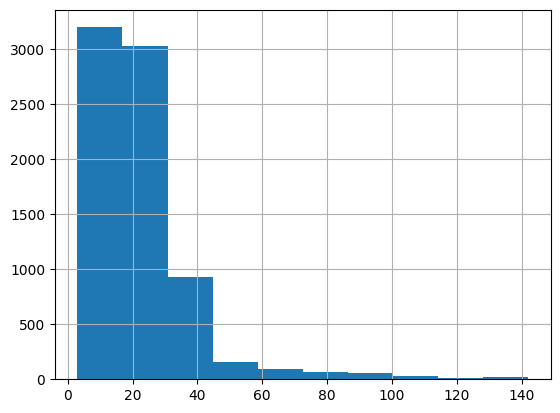

In [13]:
df.hist()

Vemos que el 95% de los textos tienen una longitud menor o igual que 49 tokens. Vamos a seleccionar una tamaño máximo de 50.

Definimos la función que vamos a usar para tokenizar todos los splits:


In [14]:
MAX_LEN = 50

def tokenize(examples):
    ## it applies the tokenzier on the dataset in its field text
    # we could add max_length = MAX_LENGHT, but in this case is not neccesary because MAX_LENTH is already 512, the maximum length allowed by the model
    return tokenizer(examples["text"], truncation=True, max_length=MAX_LEN, padding='max_length')


data_encodings=dict_dataset.map(tokenize, batched=True)
data_encodings


Map:   0%|          | 0/7592 [00:00<?, ? examples/s]

Map:   0%|          | 0/3881 [00:00<?, ? examples/s]

Map:   0%|          | 0/1899 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'language', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7592
    })
    test: Dataset({
        features: ['text', 'label', 'language', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3881
    })
    validation: Dataset({
        features: ['text', 'label', 'language', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1899
    })
})

Borramos los campos que no se utilizarán durante el training.

In [15]:
data_encodings = data_encodings.remove_columns(['text','language'])
data_encodings

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7592
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3881
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1899
    })
})

Comprobamos que todas las secuencias tienen una longitud máxima de 50 tokens.

In [16]:
for i in range(10):
    print(len(data_encodings['train'][i]['input_ids']), end=' ')


50 50 50 50 50 50 50 50 50 50 

Mostramos también el encoding del primer texto:

In [17]:
print(dict_dataset['train'][0])
print(data_encodings['train'][0]['input_ids'])
# we can again to obtain the words that corresponde to each index
print(tokenizer.decode(data_encodings['train'][0]['input_ids']))


{'text': '@user 多了帽子跟抽繩 應該 是 這樣 吧', 'label': 1.8, 'language': 'Chinese'}
[101, 137, 24934, 2967, 1728, 3480, 3155, 8247, 3989, 6684, 3877, 7837, 4353, 8473, 4768, 2450, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[CLS] @ user 多 了 帽 子 跟 抽 繩 應 該 是 這 樣 吧 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


Ya podemos cargar el modelo pre-enrenado.

Para ello vamos a usar la clase **AutoModelForSequenceClassification**. En este caso, el número de labels será siempre 1, porque no es un tarea de clasificación, sino un problema de regresión. Este valor de 1, hace que la clase **AutoModelForSequenceClassification** utilice regresión liner y MSELoss para calcular la función de error automáticamente.


In [18]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = 1).to("cuda")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Debemos definir una función que calculará las métricas en cada epoch sobre el conjunto de validación. Usaremos métricas específicas para regresión.

In [19]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from scipy import stats

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    # loss metrics
    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

    # performance metrics
    r2 = r2_score(labels, logits)

    # devolvemos un diccionario con todas las métricas y los valores obtenidos en la evaluación
    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}

Respecto a los hiper-parámetros:

In [20]:
from transformers import TrainingArguments

NUM_EPOCHS = 3

training_args = TrainingArguments(
    output_dir ='./results',
    num_train_epochs = NUM_EPOCHS,
    per_device_train_batch_size = 64, # 128 in the paper
    per_device_eval_batch_size = 20,
    weight_decay = 0.01,
    learning_rate = 2e-5,  # 0.001 in the paper,
    logging_dir = './logs',
    save_total_limit = 10,
    load_best_model_at_end = True,
    metric_for_best_model = 'rmse',
    evaluation_strategy = "epoch",  # steps in the paper
    save_strategy = "epoch",    # steps in the paper
    report_to = 'all',
)

Ya estamos listos para entrenar el modelo:

In [21]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = data_encodings['train'],
    eval_dataset = data_encodings['validation'],
    compute_metrics = compute_metrics_for_regression,
)

trainer.train()


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,0.498415,0.498415,0.705985,0.552901,0.373028,27.139804
2,No log,0.531332,0.531332,0.728926,0.575380,0.331620,27.919674
3,No log,0.504947,0.504947,0.710596,0.551835,0.364812,26.889806


TrainOutput(global_step=357, training_loss=0.5593066389153317, metrics={'train_runtime': 250.2073, 'train_samples_per_second': 91.029, 'train_steps_per_second': 1.427, 'total_flos': 585211288240800.0, 'train_loss': 0.5593066389153317, 'epoch': 3.0})

Evaluamos el modelo final sobre el conjunto de validación:

In [22]:
trainer.evaluate()

{'eval_loss': 0.5313324928283691,
 'eval_mse': 0.5313324928283691,
 'eval_rmse': 0.7289255857467651,
 'eval_mae': 0.5753800868988037,
 'eval_r2': 0.3316199722142834,
 'eval_smape': 27.919674006055818,
 'eval_runtime': 5.4456,
 'eval_samples_per_second': 348.72,
 'eval_steps_per_second': 17.445,
 'epoch': 3.0}

## Evaluación


El trainer podría ser directamente evaluado sobre el conjunto test:

In [23]:
trainer.eval_dataset = data_encodings['test']
trainer.evaluate()

{'eval_loss': 0.7457712888717651,
 'eval_mse': 0.7457712888717651,
 'eval_rmse': 0.8635805249214172,
 'eval_mae': 0.6691402196884155,
 'eval_r2': 0.1991889348737962,
 'eval_smape': 31.259263881731513,
 'eval_runtime': 13.2165,
 'eval_samples_per_second': 293.649,
 'eval_steps_per_second': 14.754,
 'epoch': 3.0}


Aunque ya hemos obtenido una primera evaluación sobre el conjunto test, vamos a definir una función que pueda ser aplicada a cualquier texto para predecir su puntuación. Esta función nos permitirá obtener las prediciones para todo el conjunto test, y evaluar cada subconjunto (idioma) por separado.

In [24]:
def get_prediction(text):
    inputs = tokenizer(text, max_length=MAX_LEN, padding="max_length", truncation=True, return_tensors="pt").to("cuda")
    outputs = model(**inputs)
    return outputs[0].item()

Aplicamos la función a todos los textos del test:

In [25]:
y_pred=[get_prediction(text) for text in dict_dataset['test']['text']]
y_pred[:5]

[1.6913310289382935,
 2.6487207412719727,
 1.551012635231018,
 2.3625361919403076,
 3.3903985023498535]

Definimos una función que nos permita imprimir las métricas en formato tabla:

In [26]:
# from sklearn.metrics import explained_variance_score

def print_metrics(y_test, y_pred, lang=''):
    if lang:
        pass
    else:
        #         print("Final results on the whole test dataset")
        print('|   |MSE|RMSE|MAE|R2|SMAPE|PEARSON|')
        print('|---|---|---|---|---|---|---|')

    mse = mean_squared_error(y_test, y_pred)
    # print ("MSE: ", "{:.2f}".format(mse), end=', ')

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # print("RMSE: ", "{:.2f}".format(rmse), end=', ')

    mae = mean_absolute_error(y_test, y_pred)
    # print("MAE: ", "{:.2f}".format(mae), end=', ')

    r2 = r2_score(y_test, y_pred)
    # print("R2: ", "{:.2f}".format(r2), end=', ')

    diff=[label-pred for (label,pred) in zip(y_test,y_pred)]
    smape= 1/len(y_test) * np.sum(2 * np.abs(diff) / (np.abs(y_test) + np.abs(y_pred))*100)
    # print("SMAPE: ", "{:.2f}".format(smape), end=', ')

    pearson=stats.pearsonr(y_test, y_pred)[0]
    # print("PEARSON: ", "{:.2f}".format(pearson))
    # print()

    text_table=str('|')+lang+str('|') +"{:.2f}".format(mse) \
                +str('|')+"{:.2f}".format(rmse) \
                +str('|')+"{:.2f}".format(mae) \
                +str('|')+"{:.2f}".format(r2) \
                +str('|')+"{:.2f}".format(smape) \
                +str('|')+"{:.2f}".format(pearson) + str('|')

    print(text_table)
    # print()


In [27]:
print_metrics(y_test, y_pred)

|   |MSE|RMSE|MAE|R2|SMAPE|PEARSON|
|---|---|---|---|---|---|---|
||0.75|0.86|0.67|0.20|31.26|0.49|


Ahora vamos a mostrar los resultados para cada idioma:

In [28]:
print("Resultados finales para: ", MODEL_NAME)
# general results
print_metrics(y_test, y_pred)

for lang in sorted(LANGUAGES):
    test_language = dict_dataset['test'].filter(lambda example: example["language"]==lang)
    # print(lang, "number of instances instances in test dataset:", test_language.num_rows)
    # print("Example: ", test_language[0]['text'])
    y_test_lang=test_language['label']
    y_pred_lang=[get_prediction(text) for text in test_language['text']]
    print_metrics(y_test_lang, y_pred_lang, lang)


Resultados finales para:  bert-base-multilingual-uncased
|   |MSE|RMSE|MAE|R2|SMAPE|PEARSON|
|---|---|---|---|---|---|---|
||0.75|0.86|0.67|0.20|31.26|0.49|


Filter:   0%|          | 0/3881 [00:00<?, ? examples/s]

|Chinese|0.57|0.75|0.60|0.28|26.13|0.59|


Filter:   0%|          | 0/3881 [00:00<?, ? examples/s]

|English|0.49|0.70|0.54|0.34|27.05|0.64|


Filter:   0%|          | 0/3881 [00:00<?, ? examples/s]

|French|0.61|0.78|0.61|0.23|29.33|0.56|


Filter:   0%|          | 0/3881 [00:00<?, ? examples/s]

|Italian|0.48|0.70|0.55|0.32|28.28|0.61|


Filter:   0%|          | 0/3881 [00:00<?, ? examples/s]

|Portuguese|0.59|0.77|0.62|0.19|28.87|0.53|


Filter:   0%|          | 0/3881 [00:00<?, ? examples/s]

|Spanish|0.56|0.75|0.60|0.40|26.82|0.65|


Podemos ver que los resultados globales muestran un valor de Pearson de 0.49. Los resultados para un idioma en concreto son mejores que el resultado global.
Los idiomas con mejores resultados son Español, Inglés e Italiano.

Una posible extensión de este trabajo es ajustar otros modelos transformers como: Twitter XLM RoBERTa Base, XLM RoBERTa base, DistilBERT base, etc.

